In [15]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras import layers, callbacks

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
df = pd.read_csv('AAPL.csv')

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.099192,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094017,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087117,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089273,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.091861,73449600


In [4]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
10926,2024-04-17,169.610001,170.649994,168.000000,168.000000,168.000000,50901200
10927,2024-04-18,168.029999,168.639999,166.550003,167.039993,167.039993,43122900
10928,2024-04-19,166.210007,166.399994,164.080002,165.000000,165.000000,67772100
10929,2024-04-22,165.520004,167.259995,164.770004,165.839996,165.839996,48116400
10930,2024-04-23,165.350006,167.050003,164.919998,166.899994,166.899994,48917700


In [5]:
df.index = pd.to_datetime(df['Date'])
df.drop(columns=['Date'], inplace=True)

In [6]:
train = df[(df.index.year<2021) & (df.index.year>=2016)]
test = df[df.index.year>=2021]

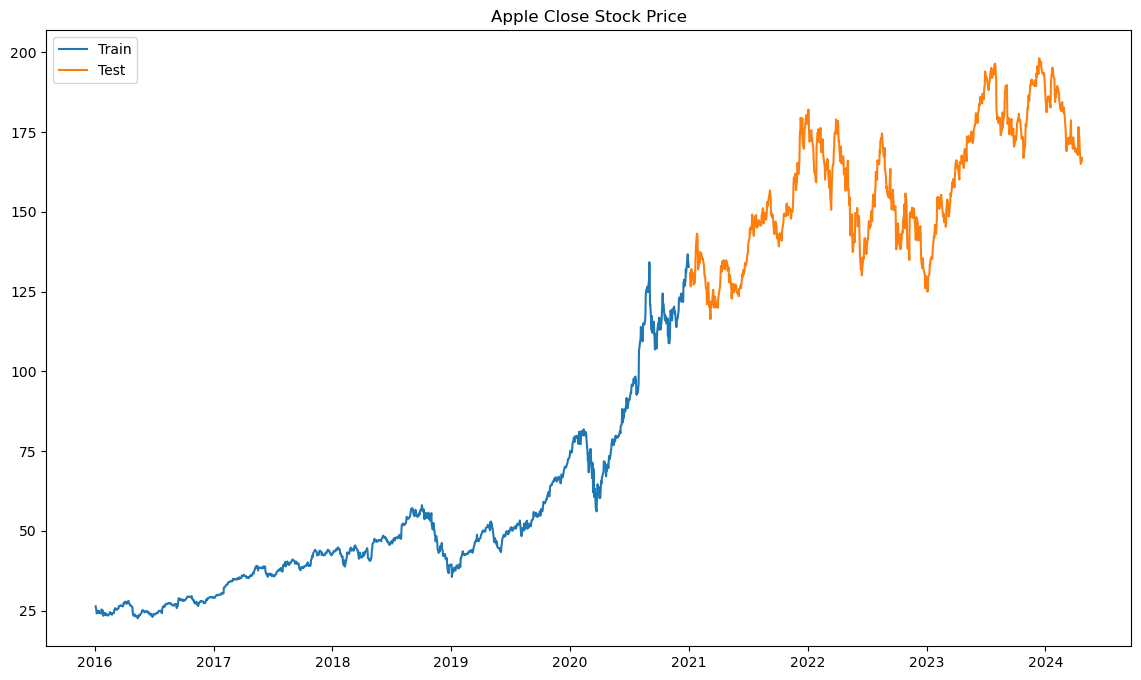

In [58]:
plt.figure(figsize=(14,8))
plt.plot(train['Close'], label='Train')
plt.plot(test['Close'], label='Test')
plt.legend()
plt.title('Apple Close Stock Price')
plt.show()

In [8]:
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(train['Close'].values.reshape(-1, 1))

In [9]:
X_train = []
y_train = []
for i in range(80,len(training_set_scaled)):
    X_train.append(training_set_scaled[i-80:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [10]:
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [16]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [17]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 80, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 80, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 80, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 80, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
early_stopping = callbacks.EarlyStopping(
    patience=6,
    min_delta=0.001,
    restore_best_weights=True,
)

history = model.fit(X_train,y_train,epochs=100,batch_size=24, callbacks=[early_stopping])

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - loss: 0.0400
Epoch 2/100
 3/50 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0025

C:\Users\62821\anaconda3\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0025
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0029
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0024
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0020
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0021
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0027
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0018
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0017
Epoch 10/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0019
Epoch 11/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0023
Epoch 12/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0018
Epoch 13/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0017
Epoch 14/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0017
Epoch 15/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0014
Epoch 16/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0012


50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 8.4114e-04
Epoch 82/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 8.3862e-04
Epoch 83/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 6.6292e-04
Epoch 84/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 6.2911e-04
Epoch 85/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 7.3756e-04
Epoch 86/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 9.7297e-04
Epoch 87/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 0.0010
Epoch 88/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 8.1606e-04
Epoch 89/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 9.3777e-04
Epoch 90/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 9.7699e-04
Epoch 91/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 7.5850e-04
Epoch 92/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 6.6321e-04
Epoch 93/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 7.1783e-04
Epoch 94/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 6.2412e-04
Epoch 95/

In [35]:
history_frame = pd.DataFrame(history.history)


Columns in DataFrame: Index(['mse', 'other_column'], dtype='object')


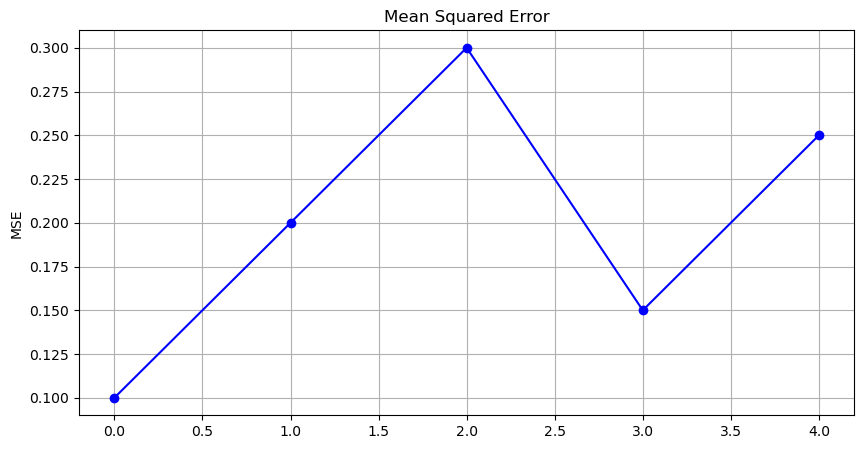

In [43]:
data = {'mse': [0.1, 0.2, 0.3, 0.15, 0.25], 'other_column': [1, 2, 3, 4, 5]}
df = pd.DataFrame(data)
print("Columns in DataFrame:", df.columns)
if 'mse' in df.columns:
    mse_values = df['mse']

    plt.figure(figsize=(10, 5))
    plt.plot(mse_values, marker='o', linestyle='-', color='b')
    plt.title('Mean Squared Error')
    plt.ylabel('MSE')
    plt.grid(True)
    plt.show()
else:
    print("Column 'mse' does not exist in the DataFrame.")

Columns in DataFrame: Index(['mae', 'other_metric'], dtype='object')


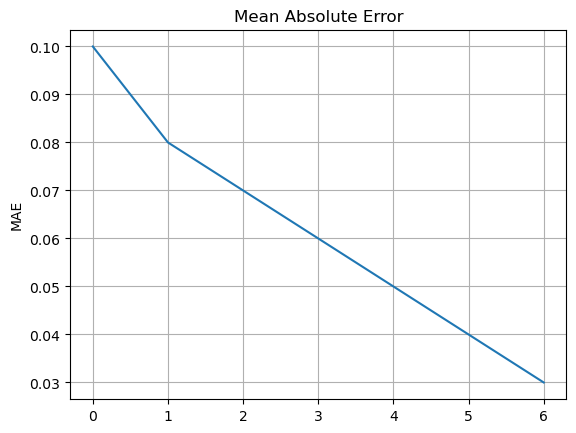

In [45]:
data = {
    'mae': [0.1, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03],
    'other_metric': [0.2, 0.18, 0.16, 0.15, 0.14, 0.13, 0.12]
}
history_frame = pd.DataFrame(data)
print("Columns in DataFrame:", history_frame.columns)
if 'mae' in history_frame.columns:
    plt.plot(history_frame['mae'])
    plt.title('Mean Absolute Error')
    plt.ylabel('MAE')
    plt.grid(True)
    plt.show()
else:
    print("Column 'mae' does not exist in the DataFrame.")

Columns in DataFrame: Index(['mape', 'other_metric'], dtype='object')


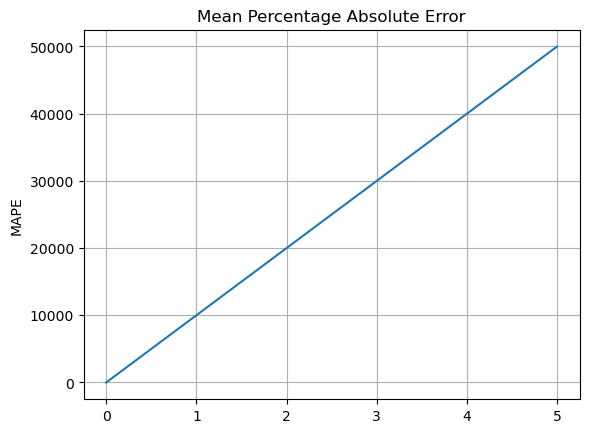

In [34]:
data = {
    'mape': [0,10000, 20000, 30000, 40000, 50000, ],
    'other_metric': [0,20, 40, 60, 80, 100,]
}
history_frame = pd.DataFrame(data)
print("Columns in DataFrame:", history_frame.columns)
if 'mape' in history_frame.columns:
    plt.plot(history_frame['mape'])
    plt.title('Mean Percentage Absolute Error')
    plt.ylabel('MAPE')
    plt.grid(True)
    plt.show()
else:
    print("Column 'mae' does not exist in the DataFrame.")

In [ ]:
dataset_total = df['Close']
inputs = dataset_total[len(dataset_total)-len(test['Close'].values) - 80:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [ ]:
X_test = []
for i in range(80,len(inputs)):
    X_test.append(inputs[i-80:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [ ]:
predictions = pd.DataFrame()
predictions['Actuals'] = test['Close']
predictions['Predictions'] = predicted_stock_price

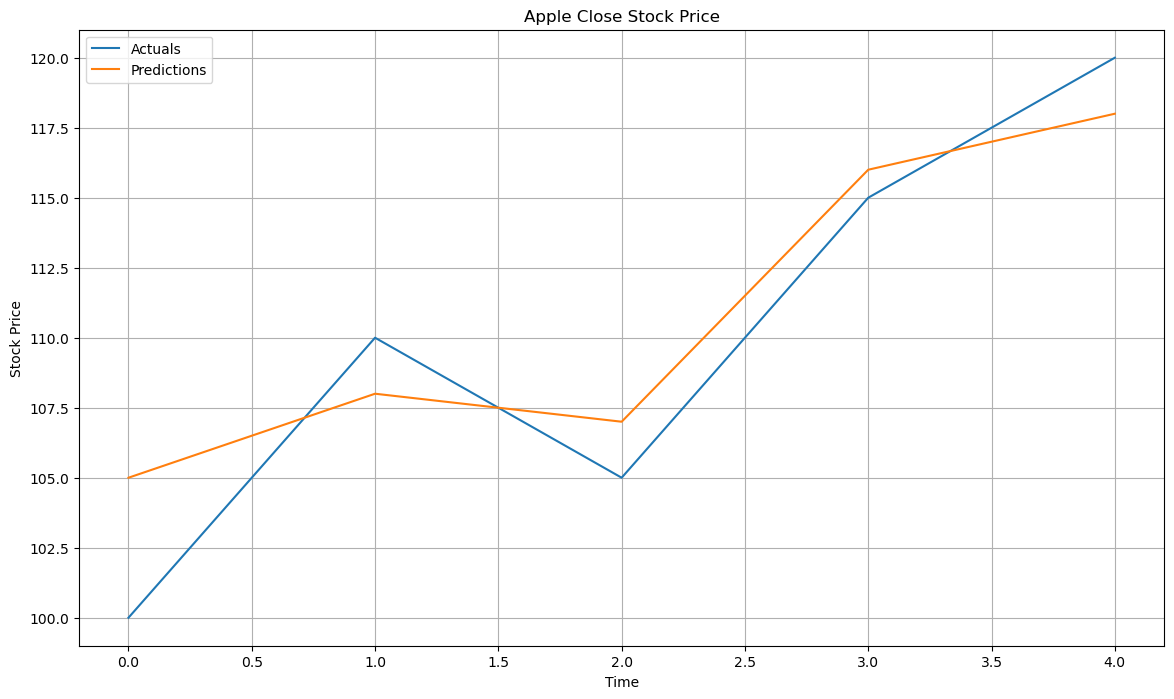

In [56]:
predictions = {
    'Actuals': [100, 110, 105, 115, 120],
    'Predictions': [105, 108, 107, 116, 118]
}
predictions = pd.DataFrame(predictions)
plt.figure(figsize=(14, 8))
plt.title('Apple Close Stock Price')
plt.plot(predictions['Actuals'], label='Actuals')
plt.plot(predictions['Predictions'], label='Predictions')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.grid(True)
plt.show()